**Components of Internal Search**
- Efficient indexing: used to quickly locate data without having to search every row in a database table every time a database table is accessed
- Attribute ranking rules: rank results by their expected relevance to a user's query using a combination of query-dependent and query-independent methods
- **Fuzzy query matching**: approximate string matches (e.g. “rmabo” vs “rambo”)
- Stemming: getting words to match each other even if they are not in the exact same form (e.g. run/runs/running/ran or cat/cats)
- Tokenization: the process of breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens

**Feature Extraction** 

Counting features: 
- length of query
- length of title
- length of description
- length of brand
- number of common grams between query and title
- number of common grams between query and description
- number of common grams between query and brand.

Statistical features: 
- ratio of title length to query length
- ratio of description length to query length
- ratio of title and query common word

###### Load Data

In [73]:
# import sample_df
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.figure import Figure
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS 

import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from gensim import corpora, models, similarities, matutils

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yichi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# import sample train_df
with open('pickle/full_description.pkl', 'rb') as picklefile: 
    description_df = pickle.load(picklefile)

# load train dataset
df_train = pd.read_csv('home-depot-product-search-relevance/train.csv', encoding="ISO-8859-1")

# combine search query and description dataframe
df_all = pd.merge(df_train, description_df, how='left', on='product_uid')

In [3]:
df_all.shape

(74067, 7)

###### Feature Extraction

In [4]:
df_all['len_searchTerm'] = df_all['search_term'].apply(lambda x:len(x.split())).astype(np.int64)
df_all['len_title'] = df_all['product_title'].apply(lambda x:len(x.split())).astype(np.int64)
df_all['len_description'] = df_all['product_description'].apply(lambda x:len(x.split())).astype(np.int64)

# The ratio of product description word length to search term word length
df_all['query_desc_len_ratio']=df_all['len_description']/df_all['len_searchTerm']

# The ratio of product title word length to search term word length
df_all['query_title_len_ratio']=df_all['len_title']/df_all['len_searchTerm']

In [5]:
df_all.shape

(74067, 12)

###### Tokenize product_title

In [6]:
# lower case all product titles
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
df_all['title_words'] = df_all['product_title'].map(alphanumeric).map(punc_lower)
df_all['search_term'] = df_all['search_term'].map(alphanumeric).map(punc_lower)

In [7]:
df_all['title_words'].iloc[25500]

'wall control   in  metal pegboard utility tool storage kit with galvanized steel pegboard and black accessories'

In [8]:
# rearrange columns
columns = df_all.columns.tolist()
columns = columns[:3] + columns[-1:] + columns[3:12]
df_all = df_all[columns]

In [9]:
df_all.head()

,id,product_uid,product_title,title_words,search_term,relevance,product_description,description_words,len_searchTerm,len_title,len_description,query_desc_len_ratio,query_title_len_ratio
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie gauge angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",angle joint stronger also provide consistent s...,2,4,129,64.500000,2.000000
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie gauge angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",angle joint stronger also provide consistent s...,2,4,129,64.500000,2.000000
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,behr premium textured deckover gal sc tu...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,hr premium textured deck innovative solid colo...,2,11,167,83.500000,5.500000
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,delta vero handle shower only faucet trim ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,update bathroom delta vero handle shower fauce...,3,13,104,34.666667,4.333333
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,delta vero handle shower only faucet trim ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,update bathroom delta vero handle shower fauce...,3,13,104,34.666667,4.333333


###### EDA

*Relevancy score is about intend, not word matching!!!*

In [10]:
irrelevant_match = df_all[df_all['relevance'] < 2]
irrelevant_match.shape

(11909, 13)

In [11]:
perfect_match = df_all[df_all['relevance'] == 3]
perfect_match.shape

(19125, 13)

Vague and short queries tend to get less relevant search result compared to longer and more concise queries

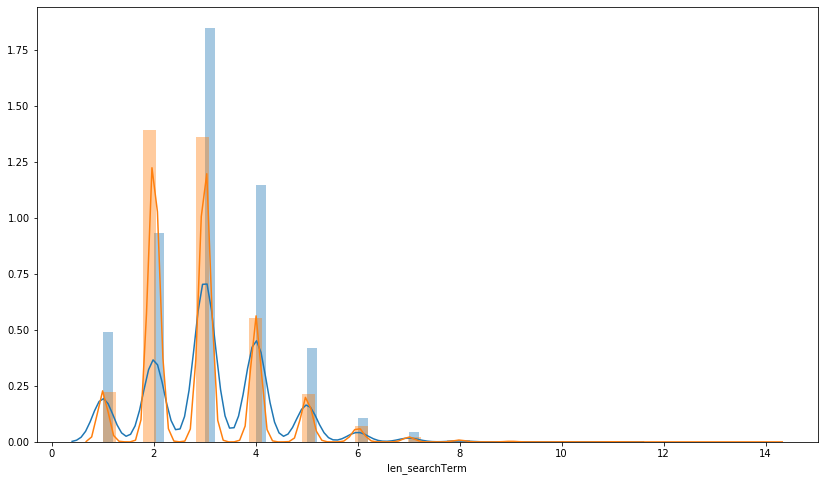

In [106]:
plt.figure(figsize=(14,8))
sns.distplot(irrelevant_match['len_searchTerm'])
sns.distplot(perfect_match['len_searchTerm'])
fig1 = plt.gcf()
fig1.savefig("pics/perfectmatch_irrelevance_searchlen.png")

Compare Query/**Title length** ratio

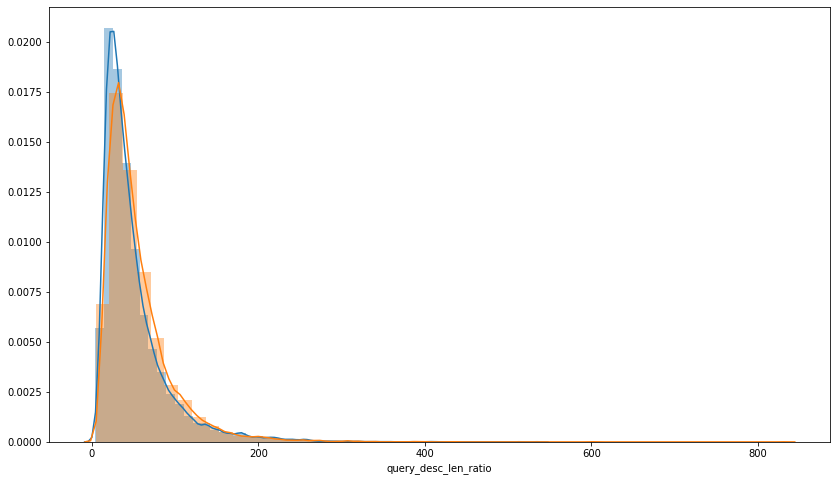

In [107]:
plt.figure(figsize=(14,8))
sns.distplot(irrelevant_match['query_desc_len_ratio'])
sns.distplot(perfect_match['query_desc_len_ratio'])
fig1 = plt.gcf()
fig1.savefig("pics/perfectmatch_irrelevance_query_desc_ratio.png")

In [15]:
# correlation
cor_df = (df_all[['relevance','len_searchTerm', 'len_title', 'len_description',
       'query_desc_len_ratio', 'query_title_len_ratio']])
cor_df.shape

(74067, 6)

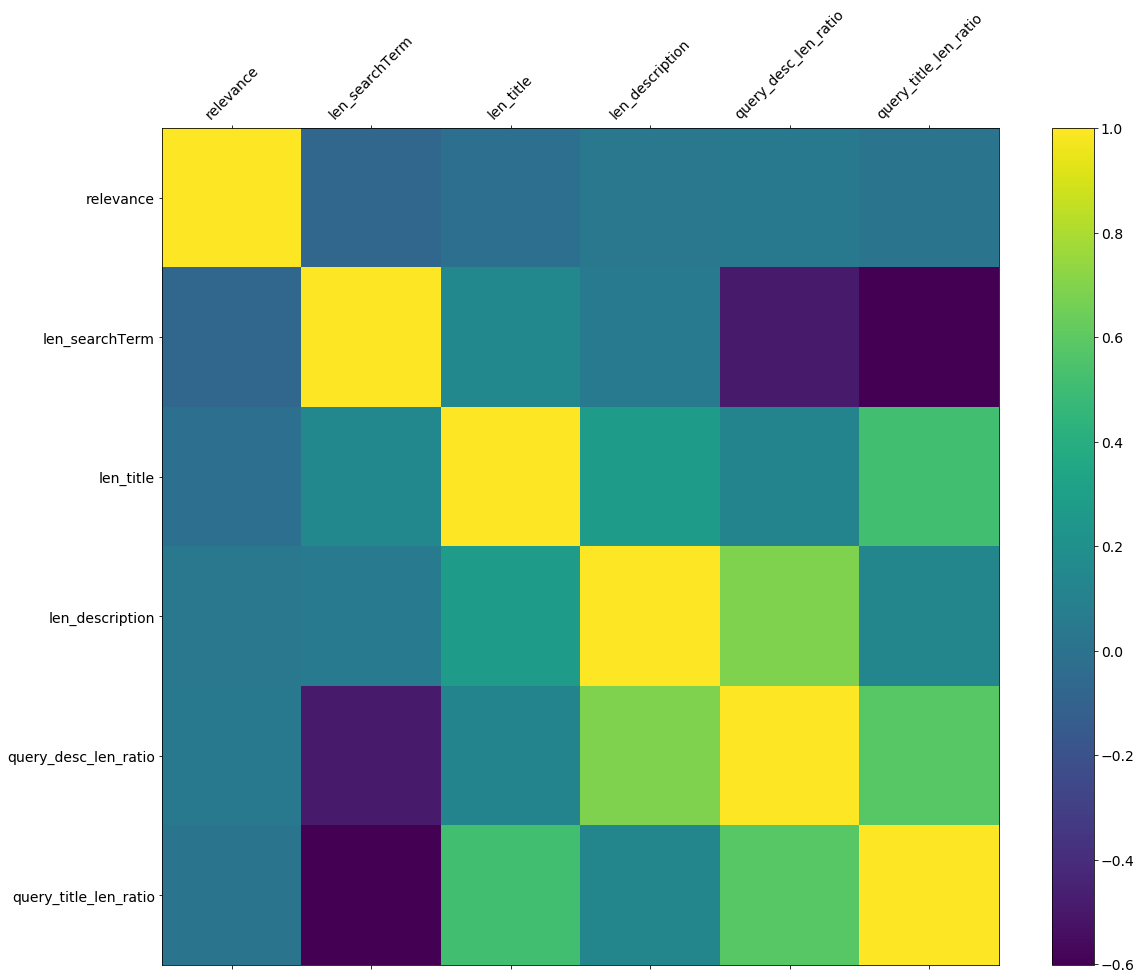

In [108]:
f = plt.figure(figsize=(19, 15))
plt.matshow(cor_df.corr(), fignum=f.number)
plt.xticks(range(cor_df.shape[1]), cor_df.columns, fontsize=14, rotation=45)
plt.yticks(range(cor_df.shape[1]), cor_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
fig1 = plt.gcf()
fig1.savefig("pics/correlation.png")

In [103]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40 
#         scale=3,
#         random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig("search_queries.png")

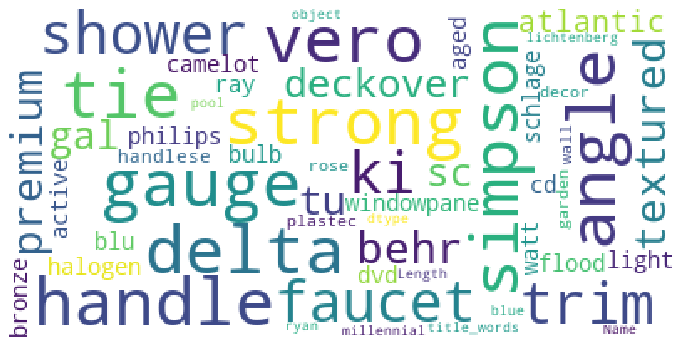

In [105]:
show_wordcloud(df_all['title_words'])

###### Top Searched Products with *Search_term*

In [46]:
# TF-IDF

tfidf = TfidfVectorizer(stop_words='english', min_df=0.005, max_df=0.8)
search_words = tfidf.fit_transform(df_all.search_term)

pd.DataFrame(search_words.toarray(), columns=tfidf.get_feature_names()).head()

,air,bar,base,bath,bathroom,battery,bay,black,bronze,bulb,...,tub,vanity,vinyl,wall,washer,water,white,window,wire,wood
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
print(tfidf.get_feature_names())

['air', 'bar', 'base', 'bath', 'bathroom', 'battery', 'bay', 'black', 'bronze', 'bulb', 'cabinet', 'cabinets', 'ceiling', 'cover', 'dewalt', 'door', 'doors', 'double', 'drill', 'electric', 'exterior', 'fan', 'faucet', 'fence', 'filter', 'floor', 'ft', 'gas', 'glass', 'heater', 'hose', 'inch', 'interior', 'kit', 'kitchen', 'led', 'light', 'lighting', 'lights', 'metal', 'outdoor', 'paint', 'panel', 'patio', 'pipe', 'plastic', 'post', 'pvc', 'range', 'replacement', 'round', 'saw', 'set', 'shower', 'sink', 'spray', 'stainless', 'steel', 'stone', 'storage', 'table', 'tile', 'toilet', 'tool', 'trim', 'tub', 'vanity', 'vinyl', 'wall', 'washer', 'water', 'white', 'window', 'wire', 'wood']


In [72]:
# Corex
doc_word = tfidf.transform(df_all.search_term)

words = list(np.asarray(tfidf.get_feature_names()))

topic_model = ct.Corex(n_hidden=8, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df_all.search_term, 
                anchors=[['door', 'tile'], 
                         ['shower'], 
                         ['paint'], 
                         ['faucet'],
                         ['light','bulb','led'], 
                         ['vanity'],
                         ['saw']], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: door,tile,interior,floor,glass,outdoor,air,doors,pipe,fan
1: shower,tub,bronze,kit,base,cabinet,drill,plastic
2: paint,spray,exterior,set,bar
3: faucet,kitchen,bath,trim
4: light,led,bulb,lights,lighting,ceiling,wood,window,patio,pvc
5: vanity,bathroom,inch,sink,white,double,black
6: saw,dewalt,table,wall
7: water,heater,gas


*Top Searched Topics:*
1. Door  2. Shower  3. Paint  4. Faucet  5. LightBulb  6. Vanity  7. Dewalt Saw  8. Water heater/Gas



###### Topics for Irrelevent Search Matches

In [93]:
# TF-IDF

tfidf = TfidfVectorizer(stop_words='english', min_df=0.005, max_df=0.5)
irrelevant_search_words = tfidf.fit_transform(irrelevant_match.search_term)

pd.DataFrame(irrelevant_search_words.toarray(), columns=tfidf.get_feature_names()).head()

,air,bar,bathroom,battery,bay,black,board,cabinet,cable,ceiling,...,toilet,tool,tub,vinyl,wall,water,white,window,wire,wood
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
search_unique_words = tfidf.fit_transform(irrelevant_match.search_term)

In [94]:
# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = tfidf.transform(irrelevant_match.search_term).transpose()
nmf_model = NMF(n_components=10, init='nndsvd', alpha=0.7)

doc_topic = nmf_model.fit_transform(doc_word)

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# Create lda model
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5)

In [95]:
for i in lda.show_topics(formatted=False):
    x = len(i[1])
    print ('topic %s' % i[0])
    print ([i[1][j][0] for j in range(10)])

topic 0
['inch', 'home', 'tool', 'toilet', 'hose', 'pipe', 'round', 'black', 'pvc', 'water']
topic 1
['cabinet', 'steel', 'round', 'window', 'bathroom', 'filter', 'glass', 'kitchen', 'outdoor', 'tool']
topic 2
['tile', 'replacement', 'tub', 'vinyl', 'bay', 'parts', 'shower', 'floor', 'hose', 'wall']
topic 3
['water', 'pipe', 'cover', 'air', 'ceiling', 'panel', 'drain', 'stove', 'plastic', 'black']
topic 4
['metal', 'floor', 'battery', 'post', 'patio', 'grill', 'cover', 'outdoor', 'light', 'window']
topic 5
['wood', 'kit', 'glass', 'lights', 'electric', 'fence', 'cable', 'garden', 'screen', 'cover']
topic 6
['kitchen', 'doors', 'bar', 'table', 'garage', 'range', 'door', 'patio', 'glass', 'wood']
topic 7
['light', 'paint', 'plastic', 'storage', 'saw', 'board', 'ft', 'foot', 'heater', 'parts']
topic 8
['white', 'wire', 'black', 'gas', 'pvc', 'fan', 'outdoor', 'wood', 'door', 'ceiling']
topic 9
['door', 'wall', 'outdoor', 'shower', 'stove', 'gas', 'bathroom', 'heater', 'inch', 'cover']


*Top **Irrelevant** Searched Topics:*
1. Plumbing Parts & Repair
2. Cabinet Accessories
3. Shower Hoses
4. Drain Grates & Plumbing
5. Outdoor Wall Lighting
6. Landscape Fabric & Supplies
7. Interior Doors
8. Paint Liners & Grids
9. Ceiling Fans
10. Patio Heater Cover